# Machine Learning for Generator Failure Prediction and Maintenance


Author: Khyle Hickey


Objective: 

To analyse generator sensor data and accurately predict time to failure so to reduce costs on maintenance programs

# Table of Contents

- [Installing libraries](#Installing-libraries)
- [Retrieving data from github and perform analysis using pandas](#Retrieving-data-from-github-and-perform-analysis-using-pandas)
- [SMOTE the Training Data](#SMOTE-the-Training-Data)
- [Build the model on the balanced training data set](#Build-the-model-on-the-balanced-training-data-set)
- [Evaluate the Model](#Evaluate-the-Model)
- [Evaluate the model using an AUC and accruacy metrics.](#Evaluate-the-model-using-an-AUC-and-accuracy-metrics.)
- [Evaluating model with a confusion matrix](#Evaluating-model-with-a-confusion-matrix)
- [Using Heuristics to Define a False Positive, True Positive, False Negative, and True Negative.](#Using-Heuristics-to-Define-a-False-Positive,-True-Positive,-False-Negative,-and-True-Negative.)
- [Apply Model and Heuristics the Training, Testing and Validation Data Sets.](#Apply-Model-and-Heuristics-the-Training,-Testing-and-Validation-Data-Sets.)
- [Conclusions](#Conclusions)

### Installing libraries

In [ ]:
#!pip install imbalanced-learn -- upgrade
!pip install plotly --upgrade
!pip install chart-studio --upgrade
!pip install xgboost --upgrade
!pip install wget --upgrade
!pip install matplotlib

In [2]:
!pip install scikit-learn==0.23.1
!pip install imbalanced-learn==0.7.0

Importing Libraries

In [3]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly as plotly
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import types
import pandas as pd
import urllib.request

def __iter__(self): return 0


### Retrieving data from github and perform analysis using pandas

In [4]:
#!wget https://raw.githubusercontent.com/KhyleHickey/Python-projects/master/ai4i2020.csv
url = "https://raw.githubusercontent.com/KhyleHickey/Python-projects/master/generator_data.csv"
file = "generator_data.csv"
urllib.request.urlretrieve(url, file)



('generator_data.csv', <http.client.HTTPMessage at 0x1f04875e580>)

In [5]:
# Convert csv to pandas dataframe
pd_data_1 = pd.read_csv("generator_data.csv", sep=",", header=0)

In [6]:
pd_data_1.head()

,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure
0,1,5/6/1994,M14860,34.747965,3.708370,93.932837,0.007661,6.822525,901,0
1,2,5/7/1994,M14860,36.137662,2.280414,95.061622,0.008288,7.099404,838,0
2,3,5/8/1994,M14860,42.024648,4.758938,88.666506,0.008843,11.609655,848,0
3,4,5/9/1994,M14860,37.039511,2.609166,112.042586,0.007071,9.176312,931,0
4,5,5/10/1994,M14860,38.719679,4.503190,86.962349,0.007160,7.448912,894,0


In [7]:
pd_data_1.shape

(10000, 10)

In [8]:
xxxx = pd.DataFrame(pd_data_1.groupby(['ID']).agg(['count']))
xxxx.shape

(10, 9)

In [9]:
xxxx = pd.DataFrame(pd_data_1.groupby(['Date']).agg(['count']))
xxxx.shape

(10000, 9)

In [10]:
pd_data_1.isnull().sum(axis = 0)

UDI                                    0
Date                                   0
ID                                     0
Internal_Pressure_MPa                  0
Battery_Charging_Current_A             0
coolant_temp_C                         0
carbon_monoxide_content_gramspersec    0
Oil_Viscosity_cSt                      0
Age_days                               0
Machine_failure                        0
dtype: int64

In [11]:
xxxx = pd.DataFrame(pd_data_1.groupby(['Machine_failure'])['ID'].agg('count'))
xxxx

,ID
Machine_failure,
0,9661
1,339


In [12]:
pd_data_1.describe()

,UDI,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,40.004161,3.509621,96.308245,0.007158,8.997876,875.772900,0.033900
std,2886.89568,4.618268,0.863369,17.155702,0.001784,2.310666,31.802281,0.180981
min,1.00000,32.000742,2.000785,67.000362,0.000680,5.000335,822.000000,0.000000
25%,2500.75000,36.012740,2.765754,81.131280,0.005943,7.006941,848.000000,0.000000
50%,5000.50000,39.999792,3.513385,96.192088,0.007178,9.015949,876.000000,0.000000
75%,7500.25000,44.045324,4.258305,111.246484,0.008377,10.980296,903.000000,0.000000
max,10000.00000,47.998109,4.999683,125.993733,0.013711,12.999123,931.000000,1.000000


Analyze correlation between independent variables(sensor values) and dependent variable(machine failure)

In [13]:
xxx=pd_data_1.corr( method='pearson')

xxx=xxx[['Machine_failure']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['Machine_failure'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])

In [14]:
xxx

,Machine_failure,ABS_EQUIPMENT_FAILURE
Machine_failure,1.000000,1.000000
carbon_monoxide_content_gramspersec,0.191321,0.191321
UDI,-0.022892,0.022892
Age_days,-0.016177,0.016177
Battery_Charging_Current_A,-0.011534,0.011534
Internal_Pressure_MPa,-0.009952,0.009952
coolant_temp_C,-0.006622,0.006622
Oil_Viscosity_cSt,-0.004875,0.004875


In [15]:
pd_data_1['Date'] = pd.to_datetime(pd_data_1['Date'])

In [16]:
pd_data_1=pd_data_1.sort_values(by=['ID','Date'], ascending=[True, True])

pd_data_1['flipper'] = np.where((pd_data_1.ID != pd_data_1.ID.shift(1)), 1, 0)
pd_data_1.head()

,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure,flipper
3000,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,1
3001,3002,2002-07-24,H29424,33.254299,2.829795,70.210499,0.007858,10.926638,881,0,0
3002,3003,2002-07-25,H29424,44.122980,2.877520,89.261397,0.006963,8.228768,864,0,0
3003,3004,2002-07-26,H29424,42.620755,3.964376,78.984041,0.007590,11.114865,901,0,0
3004,3005,2002-07-27,H29424,37.651749,3.786467,87.421129,0.009523,5.877065,889,0,0


In [136]:
#define feature window. This is the window by which we will aggregate sensor values for running means, max, min, etc.
feature_window=28

In [18]:
dfx=pd_data_1

In [19]:
#Select the first record of each machine

starter=dfx[dfx['flipper'] == 1]

starter=starter[['Date','ID']]

In [20]:
#rename date to start_date
starter=starter.rename(index=str, columns={"Date": "START_DATE"})

In [21]:
#convert START_DATE to date
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [22]:
#Merge START_DATE to the original data set

dfx=dfx.sort_values(by=['ID', 'Date'], ascending=[True, True])
starter=starter.sort_values(by=['ID'], ascending=[True])
dfx =dfx.merge(starter, on=['ID'], how='left')

In [23]:
# calculate the number of days since the beginning of each well. 
dfx['C'] = dfx['Date'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window) , 1, 0)

Create a running mean, max, min, and median for the sensor variables.

In [24]:
dfx['pressure_mean'] = np.where((dfx.too_soon == 0),(dfx['Internal_Pressure_MPa'].rolling(min_periods=1, window=feature_window).mean()) , dfx.Internal_Pressure_MPa)
dfx['pressure_median'] = np.where((dfx.too_soon == 0),(dfx['Internal_Pressure_MPa'].rolling(min_periods=1, window=feature_window).median()) , dfx.Internal_Pressure_MPa)
dfx['pressure_max'] = np.where((dfx.too_soon == 0),(dfx['Internal_Pressure_MPa'].rolling(min_periods=1, window=feature_window).max()) , dfx.Internal_Pressure_MPa)
dfx['pressure_min'] = np.where((dfx.too_soon == 0),(dfx['Internal_Pressure_MPa'].rolling(min_periods=1, window=feature_window).min()) , dfx.Internal_Pressure_MPa)

dfx['current_mean'] = np.where((dfx.too_soon == 0),(dfx['Battery_Charging_Current_A'].rolling(min_periods=1, window=feature_window).mean()) , dfx.Battery_Charging_Current_A)
dfx['current_median'] = np.where((dfx.too_soon == 0),(dfx['Battery_Charging_Current_A'].rolling(min_periods=1, window=feature_window).median()) , dfx.Battery_Charging_Current_A)
dfx['current_max'] = np.where((dfx.too_soon == 0),(dfx['Battery_Charging_Current_A'].rolling(min_periods=1, window=feature_window).max()) , dfx.Battery_Charging_Current_A)
dfx['current_min'] = np.where((dfx.too_soon == 0),(dfx['Battery_Charging_Current_A'].rolling(min_periods=1, window=feature_window).min()) , dfx.Battery_Charging_Current_A)

dfx['ctemp_mean'] = np.where((dfx.too_soon == 0),(dfx['coolant_temp_C'].rolling(min_periods=1, window=feature_window).mean()) , dfx.coolant_temp_C)
dfx['ctemp_median'] = np.where((dfx.too_soon == 0),(dfx['coolant_temp_C'].rolling(min_periods=1, window=feature_window).median()) , dfx.coolant_temp_C)
dfx['ctemp_max'] = np.where((dfx.too_soon == 0),(dfx['coolant_temp_C'].rolling(min_periods=1, window=feature_window).max()) , dfx.coolant_temp_C)
dfx['ctemp_min'] = np.where((dfx.too_soon == 0),(dfx['coolant_temp_C'].rolling(min_periods=1, window=feature_window).min()) , dfx.coolant_temp_C)

dfx['CO_mean'] = np.where((dfx.too_soon == 0),(dfx['carbon_monoxide_content_gramspersec'].rolling(min_periods=1, window=feature_window).mean()) , dfx.carbon_monoxide_content_gramspersec)
dfx['CO_median'] = np.where((dfx.too_soon == 0),(dfx['carbon_monoxide_content_gramspersec'].rolling(min_periods=1, window=feature_window).median()) , dfx.carbon_monoxide_content_gramspersec)
dfx['CO_max'] = np.where((dfx.too_soon == 0),(dfx['carbon_monoxide_content_gramspersec'].rolling(min_periods=1, window=feature_window).max()) , dfx.carbon_monoxide_content_gramspersec)
dfx['CO_min'] = np.where((dfx.too_soon == 0),(dfx['carbon_monoxide_content_gramspersec'].rolling(min_periods=1, window=feature_window).min()) , dfx.carbon_monoxide_content_gramspersec)

dfx['viscosity_mean'] = np.where((dfx.too_soon == 0),(dfx['Oil_Viscosity_cSt'].rolling(min_periods=1, window=feature_window).mean()) , dfx.Oil_Viscosity_cSt)
dfx['viscosity_median'] = np.where((dfx.too_soon == 0),(dfx['Oil_Viscosity_cSt'].rolling(min_periods=1, window=feature_window).median()) , dfx.Oil_Viscosity_cSt)
dfx['viscosity_max'] = np.where((dfx.too_soon == 0),(dfx['Oil_Viscosity_cSt'].rolling(min_periods=1, window=feature_window).max()) , dfx.Oil_Viscosity_cSt)
dfx['viscosity_min'] = np.where((dfx.too_soon == 0),(dfx['Oil_Viscosity_cSt'].rolling(min_periods=1, window=feature_window).min()) , dfx.Oil_Viscosity_cSt)



dfx.head()

,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure,...,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min
0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,...,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736
1,3002,2002-07-24,H29424,33.254299,2.829795,70.210499,0.007858,10.926638,881,0,...,70.210499,70.210499,0.007858,0.007858,0.007858,0.007858,10.926638,10.926638,10.926638,10.926638
2,3003,2002-07-25,H29424,44.122980,2.877520,89.261397,0.006963,8.228768,864,0,...,89.261397,89.261397,0.006963,0.006963,0.006963,0.006963,8.228768,8.228768,8.228768,8.228768
3,3004,2002-07-26,H29424,42.620755,3.964376,78.984041,0.007590,11.114865,901,0,...,78.984041,78.984041,0.007590,0.007590,0.007590,0.007590,11.114865,11.114865,11.114865,11.114865
4,3005,2002-07-27,H29424,37.651749,3.786467,87.421129,0.009523,5.877065,889,0,...,87.421129,87.421129,0.009523,0.009523,0.009523,0.009523,5.877065,5.877065,5.877065,5.877065


Another useful transformation is to look for sudden spikes in sensor values. This code creates a value indicating how far the current value is from the immediate norm.


In [25]:
dfx['pressure_chg'] = np.where((dfx.pressure_mean == 0),0 , dfx.Internal_Pressure_MPa/dfx.pressure_mean)
dfx['current_chg'] = np.where((dfx.current_mean == 0),0 , dfx.Battery_Charging_Current_A/dfx.current_mean)
dfx['ctemp_chg'] = np.where((dfx.ctemp_mean == 0),0 , dfx.coolant_temp_C/dfx.ctemp_mean)
dfx['CO_chg'] = np.where((dfx.CO_mean == 0),0 , dfx.carbon_monoxide_content_gramspersec/dfx.CO_mean)
dfx['viscosity_chg'] = np.where((dfx.viscosity_mean == 0),0 , dfx.Oil_Viscosity_cSt/dfx.viscosity_mean)

In [26]:
#copy the data set to the original name
pd_data_1=dfx

Because machines generally last a long time, we typically do not have many examples of failure. This means the data sets we use in PM are almost always unbalanced.

One way to increase the number of failures is to expand the failure or target window. That is, make the dependent variable, not just the day the equipment failed but the 28 days (or another appropriate interval) leading up to the failure.

In [27]:
target_window=28

Sort the data and reset the index.

In [28]:
pd_data_1=pd_data_1.sort_values(by=['ID', 'Date'], ascending=[True, True])
pd_data_1.reset_index(level=0, inplace=True)

Create a new data frame that contains the failure records. Rename DATE to FAILURE_DATE

In [29]:
df_failure_thingy=pd_data_1[pd_data_1['Machine_failure'] == 1]

df_failure_thingy=df_failure_thingy[['Date','ID']]

df_failure_thingy=df_failure_thingy.rename(index=str, columns={"Date": "FAILURE_DATE"})

pd_data_1=pd_data_1.sort_values(by=['ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['ID'], ascending=[True])

Append the FAILURE_DATE to each ID.

In [30]:
pd_data_1 =pd_data_1.merge(df_failure_thingy, on=['ID'], how='left')

For each record, calculate the number of days until failure.

In [31]:
pd_data_1=pd_data_1.sort_values(by=['ID','Date'], ascending=[True, True])

pd_data_1['FAILURE_DATE'] = pd.to_datetime(pd_data_1['FAILURE_DATE'])
pd_data_1['Date'] = pd.to_datetime(pd_data_1['Date'])
pd_data_1['C'] = pd_data_1['FAILURE_DATE'] - pd_data_1['Date']

pd_data_1['TIME_TO_FAILURE'] = pd_data_1['C'] / np.timedelta64(1, 'D')

Clean up and sort the records by ID and DATE

In [32]:
pd_data_1=pd_data_1.drop(columns=['index'])

In [33]:
pd_data_1=pd_data_1.sort_values(by=['ID', 'Date'], ascending=[True, True])

In [34]:
pd_data_1.reset_index(inplace=True)

In [35]:
pd_data_1.head()

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,...,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,C,TIME_TO_FAILURE
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2002-07-23,0 days,0.0
1,1,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-20,943 days,943.0
2,2,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-12,935 days,935.0
3,3,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-05,928 days,928.0
4,4,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2004-12-06,867 days,867.0


Create a new variable, FAILURE_TARGET. It is equal to 1 if the record proceeds a failure by "failure_window" days or less.

In [36]:
pd_data_1['FAILURE_TARGET'] = np.where(((pd_data_1.TIME_TO_FAILURE < target_window) & ((pd_data_1.TIME_TO_FAILURE>=0))), 1, 0)

pd_data_1.head()

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,...,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,1.0,1.0,1.0,1.0,1.0,2002-07-23,0 days,0.0,1
1,1,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-20,943 days,943.0,0
2,2,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-12,935 days,935.0,0
3,3,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-05,928 days,928.0,0
4,4,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,9.277736,1.0,1.0,1.0,1.0,1.0,2004-12-06,867 days,867.0,0


In [37]:
tips_summed = pd_data_1.groupby(['FAILURE_TARGET'])['Internal_Pressure_MPa'].count()
tips_summed

FAILURE_TARGET
0    329659
1      9341
Name: Internal_Pressure_MPa, dtype: int64

The new field occurs about 2.8% of the time.

In [38]:
pd_data_1['FAILURE_TARGET'].mean()

0.02755457227138643

 use SMOTE to increase the number of failures synthetically then split data into training, testing, and a validation sample 

randomly select IDs and place all of the records for each machine in either the training, testing, or validation data set.

In [39]:
#Get a Unique List of All IDs 


aa=pd_data_1

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

(10, 1)

Create a new variable with a random number between 0 and 1

In [40]:
np.random.seed(42)

In [41]:
pd_id['wookie'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000

In [42]:
pd_id=pd_id[['ID', 'wookie']]

Give each record a 30% chance of being in the validation, a 35% chance of being in the testing, and a 35% chance of being in the training data set.

In [43]:
pd_id['MODELING_GROUP'] = np.where(((pd_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))

This is how many machines fall in each group.

In [44]:
tips_summed = pd_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       2
TRAINING      2
VALIDATION    6
Name: wookie, dtype: int64

Append the Group of each id to each individual record.

In [45]:
pd_data_1=pd_data_1.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])

In [46]:
pd_data_1 =pd_data_1.merge(pd_id, on=['ID'], how='inner')

pd_data_1.head()

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,...,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET,wookie,MODELING_GROUP
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,...,1.000000,1.00000,1.000000,1.000000,2002-07-23,0 days,0.0,1,0.727,TESTING
1,268,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,...,1.332434,0.79974,0.991216,0.745969,2004-02-22,-87 days,-87.0,0,0.727,TESTING
2,267,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,...,1.332434,0.79974,0.991216,0.745969,2004-01-03,-137 days,-137.0,0,0.727,TESTING
3,266,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,...,1.332434,0.79974,0.991216,0.745969,2004-01-02,-138 days,-138.0,0,0.727,TESTING
4,265,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,...,1.332434,0.79974,0.991216,0.745969,2003-10-23,-209 days,-209.0,0,0.727,TESTING


This is how many records are in each group.

In [47]:
tips_summed = pd_data_1.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING        50000
TRAINING       39000
VALIDATION    250000
Name: wookie, dtype: int64

This is how many failure targets are in each group.

In [48]:
tips_summed = pd_data_1.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
tips_summed

MODELING_GROUP
TESTING       1362
TRAINING      1075
VALIDATION    6904
Name: FAILURE_TARGET, dtype: int32

Create a separate data frame for the training data. We will use this data set to build the model.

In [49]:
df_training=pd_data_1[pd_data_1['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_training.shape

(39000, 40)

Create a separate data frame for the training and testing data sets. We will use this to tweak our modeling results.

In [50]:
df_train_test=pd_data_1[pd_data_1['MODELING_GROUP'] != 'VALIDATION']

df_train_test=df_train_test.drop(columns=['wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_train_test.shape

(89000, 42)

Create a separate data frame for all the data. We will use this to validate the model and compare the accuracy of all groups.

In [51]:
df_total=pd_data_1.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_total.shape

(339000, 41)

#### SMOTE the Training Data 

Note that we are only balancing the training data set. You may be asking why. Remember that our goal is to build a model the represents reality, right? When we SMOTE the data, we change the failure rate to 50%. This is nowhere near what we see in the actual machine data. Thus, it makes sense to build the model on the SMOTE data but evaluate it on the unaltered data. The unaltered data will be a better reflection of what to expect when you deploy the model to production.

Define the Training features and Target.

In [52]:
training_features=df_training[["Internal_Pressure_MPa",
                               "Battery_Charging_Current_A", 
                               "coolant_temp_C", 
                               "carbon_monoxide_content_gramspersec", 
                               "Oil_Viscosity_cSt", 
                               "Age_days", 
                               "pressure_mean", "pressure_median", "pressure_max", "pressure_min", 
                               "current_mean", "current_median", "current_max", "current_min",
                               "ctemp_mean", "ctemp_median", "ctemp_max", "ctemp_min",
                               "CO_mean", "CO_median", "CO_max", "CO_min",
                               "viscosity_mean", "viscosity_median", "viscosity_max", "viscosity_min",
                               "pressure_chg",
                               "current_chg",
                               "ctemp_chg",
                               "CO_chg",
                               "viscosity_chg"]]

In [53]:
training_target=df_training[['FAILURE_TARGET']]

Synthetically Balance the training data sets with a SMOTE algorithm. After we apply the SMOTE algorithm, we will have a balanced data set. 50% Failures and 50% Non-Failures. 

In [54]:
#uncomment these options if you want to expand the number of rows and columns that appear visually on the screen.

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [55]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [56]:
x_res, y_res = smx.fit_sample(training_features, training_target.values.ravel())

Convert the SMOTE output back to complete data frames with independent and dependent variables. Examine the results.

Format the Independent Variables.

In [57]:
df_x=pd.DataFrame(x_res)

df_x.columns = ["Internal_Pressure_MPa",
                               "Battery_Charging_Current_A", 
                               "coolant_temp_C", 
                               "carbon_monoxide_content_gramspersec", 
                               "Oil_Viscosity_cSt", 
                               "Age_days", 
                               "pressure_mean", "pressure_median", "pressure_max", "pressure_min", 
                               "current_mean", "current_median", "current_max", "current_min",
                               "ctemp_mean", "ctemp_median", "ctemp_max", "ctemp_min",
                               "CO_mean", "CO_median", "CO_max", "CO_min",
                               "viscosity_mean", "viscosity_median", "viscosity_max", "viscosity_min",
                               "pressure_chg",
                               "current_chg",
                               "ctemp_chg",
                               "CO_chg",
                               "viscosity_chg"]
df_x.head()

,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,pressure_mean,pressure_median,pressure_max,pressure_min,current_mean,current_median,current_max,current_min,ctemp_mean,ctemp_median,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg
0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
1,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
2,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
3,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
4,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763


Format the Dependent Variable

In [58]:
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

Check that the dependent variable is balanced. Dependent variable is balanced when the mean equals 0.5

In [59]:
df_y.mean(axis = 0) 

FAILURE_TARGET    0.5
dtype: float64

Merge the dependent and independent variables after SMOTE into a data frame.

In [60]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

,FAILURE_TARGET,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,pressure_mean,pressure_median,pressure_max,pressure_min,current_mean,current_median,current_max,current_min,ctemp_mean,ctemp_median,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg
0,0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
1,0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
2,0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
3,0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763
4,0,41.711642,3.701497,87.120512,0.007607,7.12829,860,40.716688,41.604734,47.732641,32.701989,3.650716,3.689776,4.911692,2.287786,94.99378,91.780938,123.000108,67.012633,0.007965,0.008046,0.011062,0.004905,8.195672,8.383156,12.165222,5.056613,1.024436,1.01391,0.917118,0.955133,0.869763


Convert the categorical variables into binary dummy variables. We need to do this because the XGBT model (below) doesn't like categorical fields

In [61]:
"""
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_balanced= pd.concat([df_balanced, df_dv], axis=1)
"""

'\ndf_dv = pd.get_dummies(df_balanced[\'REGION_CLUSTER\'])\n\ndf_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})\n\n\ndf_balanced= pd.concat([df_balanced, df_dv], axis=1)\n'

### Build the model on the balanced training data set 

In the balanced data set, separate the dependent and independent variables to feed the model development process.

In [62]:
features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])

independent=df_balanced.drop(columns=['FAILURE_TARGET'])

In [63]:
#make sure everything is numeric for simplicity
#independent = independent.apply(pd.to_numeric) 
#df_balanced = df_balanced.apply(pd.to_numeric)

Define model specs.

In [64]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

We are initializing our model with default model parameters. Note that we could probably improve the results by tweaking the parameters, but we will save that exercise for another day.

In [65]:
xgb0 = XGBClassifier(
 objective= 'binary:logistic', use_label_encoder=False) #use_label_encoder=False

### Evaluate the Model

Probably the most confusing element of PM problems is building a realistic assessment of the model. Because of timing and the small number of failures, understanding how the model will work once deployed in production is challenging.

#### Evaluate the model using an AUC and accuracy metrics.

First, we will evaluate the balanced training data with the default, a 50% cut-off.

For information on how to find the best cut-off for these types of problems:
https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c


Model Report
Accuracy : 0.9808
AUC Score (Balanced): 0.995133


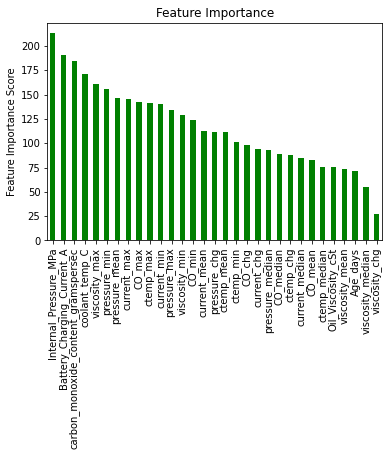

In [66]:
evaluate_model(xgb0, independent, dependent,features) 

With a cut-off of 50%, the accuracy is .9808, and the AUC is .995133 on the balanced training data.

In [67]:

df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

In [68]:


df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.9651
AUC Score (Train): 0.834468


With a 50% cut-off, we get an accuracy of .9651 and an AUC of .834468

Now, lets' try with a 67% cut-off. Probabilities larger than 67% are labeled as failures. Probabilities less than or equal to 67% are labeled as non-failures.

In [69]:
df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.9669
AUC Score (Train): 0.834468


marginal improvement, apply the model to the testing data set.

In [70]:
df_testing['P_FAIL']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_FAIL'] = np.where(((df_testing.P_FAIL <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['FAILURE_TARGET'].values, df_testing['Y_FAIL']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_testing['FAILURE_TARGET'], df_testing['P_FAIL']))

Accuracy : 0.6866
AUC Score (Test): 0.481575


### Evaluating model with a confusion matrix

A confusion matrix specifically lays out the following metrics.

True Positive. The model predicts the machine will fail, and it does.

True Negative. The model predicts the machine will not fail and it does not fail.

False Positive. The model predicts the machine will fail and it does not fail.

False Negative. The model predicts the machine will not fail and it fails.

These metrics directly correlate to the economic costs of our PM problem.

In [141]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/KhyleHickey/Python-projects/master/Maintenance_cost.png")

A false positive is “Unnecessary Maintenance.” When your model predicts failure and is not going to fail, you incur unnecessary maintenance costs.

A true positive is “Timely and Appropriate Maintenance.” When your model predicts failure, and it is going to fail, you incur timely and appropriate maintenance costs.

A false negative is “Machine Runs to Failure.” When your model does not predict failure and fails, you incur costs associated with running your machine to failure.

For this use case, this means that a false positive costs $1,500.

A false negative costs $30,000.

A true positive costs $7,500.

A true negative has no cost because no action is taken.

A confusion matrix lays out what is important for us to evaluate.

A confusion matrix is a cross-tabulation between the binary prediction of failure/non-failure and the actual binary failure/non-failure variable. Remember that we have two actual failure values.

The first is the original failure variable, 'EQUIPMENT_FAILURE.'

In [72]:
xxxx = pd.DataFrame(pd_data_1.groupby(['Machine_failure'])['ID'].agg('count'))
xxxx

,ID
Machine_failure,
0,316275
1,22725


Machine_failure has 22725 failure indicators. Remember that a '1' appears on the day that the failure occurs.

Let's examine a cross-tab of Machine_failure with the predicted binary failure variable for the testing data set ('Y_FAIL').

In [73]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.Machine_failure, dropna=False))

Machine_failure      0    1
Y_FAIL                     
0                33973  916
1                14769  342


According to the confusion matrix above, we have 342 true positives, 33973 false negatives, 14769 false positives, and 916 true negatives.  

Is this right?  

No, it isn't.  Think about it.  

The 'EQUIPMENT_FAILURE' variable identifies a failure on the day it occurs.  Let's say that failure occurs on Friday, and we have signals for failure on Monday, Tuesday, Wednesday, and Thursday, but not on Friday.  I would argue that the failure on Friday is a True Positive, given that there were four failure signals in the days leading up to the failure.  However, the confusion matrix above counts Monday, Tuesday, Wednesday, and Thursday as false positives and Friday as a false negative.  This doesn't work, does it?


Now, we will create a confusion matrix using 'FAILURE_TARGET.'  This is the predicted binary variable where the 28 days leading up to a failure are flagged with a '1'.

In [74]:
print(pd.crosstab(df_testing.Y_FAIL, df_testing.FAILURE_TARGET, dropna=False))

FAILURE_TARGET      0    1
Y_FAIL                    
0               33928  961
1               14710  401


With 'FAILURE_TARGET,' we have 401 True Positives, 33928 False Negatives, 14710 False Positives, and 961 True Negatives.  

Does this work?  

Not really, huh.  Think about it.  

Each failure is represented 28 different times. If a machine fails on Friday the 28th, the previous twenty-seven days of the month are also flagged as a failure.  

Friday can be a true positive, the previous Wednesday a true positive, and the previous Thursday a false positive.  

The example above clearly does not reflect what we can expect when we push this model into production.

So, what does all this mean?  To get an accurate accounting of how the model will work in production, we use additional logic and business rules/heuristics.

#### Using Heuristics to Define a False Positive, True Positive, False Negative, and True Negative.

To accurately evaluate our machine learning model, we first need to define a few parameters.  I usually fine-tune these parameters with the testing and training data sets, then confirm the accuracy with the validation data set.

The first parameter is the Forecast Window.  

The Forecast Window is the length of time a failure signal projects into the future.  

For example, if there is a failure signal on June 1st, how long is that signal good for?  

Does it mean the machine will break in the next second, minute, hour, day, or month? 

Note that the length of the forecast window depends on the context of the problem.  If a machine runs to failure in 10 years, the forecast window will be relatively long, perhaps as long as six or nine months.  If a machine runs to failure in 1 day, the forecast window will be much shorter, maybe an hour or a few minutes.  The length of the forecast window must be helpful to the problem.  For example, a twenty-eight-day forecast window for a machine that runs to failure in thirty days is of little value.  

In our current use case, the machine runs to failure in four to six years, so a ninety-day forecast window is reasonable.

In [75]:
forecast_window=90

Now that we defined the forecast window we will now apply it to the data.  This means that a signal is good for ninety days.  For example, if a signal appears on January 1st, that signal is good until March 31st (ninety days)

We will create a new failure indicator.  

This failure indicator (signal) can only appear every ninety days.  Note that we have panel data and must ensure that the signals don't "bleed" from one machine to the next.  For example, if a signal occurs on machine X's last possible day, we do not want the window for machine X+1 to be affected by this signal.

Score df_train_test

In [76]:
df_train_test['P_FAIL']= xgb0.predict_proba(df_train_test[features])[:,1];
df_train_test['Y_FAIL'] = np.where(((df_train_test.P_FAIL <= .67)), 0, 1)

In [77]:
#sort the data by id and date.
xx=df_train_test
xx=xx.sort_values(by=['ID','Date'], ascending=[True, True])

In [78]:
#create a unique list of machines
aa=xx

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id.shape

(4, 1)

In [79]:
#label each machine with a sequential number
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1
pd_id.head()

,SCOOBYDOO,ID
0,1,H29424
1,2,H29457
2,3,L47242
3,4,M14918


In [80]:
#grab the max number of machines +1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value

5

In [81]:
#append sequential number to main file
xx=xx.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
xx =xx.merge(pd_id, on=['ID'], how='inner')
xx.head()

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure,TIME_SINCE_START,too_soon,pressure_mean,pressure_median,pressure_max,pressure_min,current_mean,current_median,current_max,current_min,ctemp_mean,ctemp_median,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,C,FAILURE_TARGET,MODELING_GROUP,P_FAIL,Y_FAIL,SCOOBYDOO
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.000000,1.000000,1.00000,1.000000,1.000000,2002-07-23,0 days,1,TESTING,0.124587,0,1
1,244,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,0,666.0,0,41.682078,41.504817,47.931085,33.017597,3.717396,3.888271,4.970757,2.112956,93.388952,93.374953,124.124733,67.463998,0.007205,0.007187,0.010310,0.004475,8.678482,8.837123,12.412448,5.529632,1.003936,1.332434,0.79974,0.991216,0.745969,2005-02-20,277 days,0,TESTING,0.039713,0,1
2,245,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,0,666.0,0,41.682078,41.504817,47.931085,33.017597,3.717396,3.888271,4.970757,2.112956,93.388952,93.374953,124.124733,67.463998,0.007205,0.007187,0.010310,0.004475,8.678482,8.837123,12.412448,5.529632,1.003936,1.332434,0.79974,0.991216,0.745969,2005-02-12,269 days,0,TESTING,0.039713,0,1
3,246,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,0,666.0,0,41.682078,41.504817,47.931085,33.017597,3.717396,3.888271,4.970757,2.112956,93.388952,93.374953,124.124733,67.463998,0.007205,0.007187,0.010310,0.004475,8.678482,8.837123,12.412448,5.529632,1.003936,1.332434,0.79974,0.991216,0.745969,2005-02-05,262 days,0,TESTING,0.039713,0,1
4,257,3667,2004-05-19,H29424,41.846119,4.953185,74.686898,0.007142,6.473876,882,0,666.0,0,41.682078,41.504817,47.931085,33.017597,3.717396,3.888271,4.970757,2.112956,93.388952,93.374953,124.124733,67.463998,0.007205,0.007187,0.010310,0.004475,8.678482,8.837123,12.412448,5.529632,1.003936,1.332434,0.79974,0.991216,0.745969,2004-03-25,-55 days,0,TESTING,0.039713,0,1


In [82]:
#sort data
xx=xx.sort_values(by=['ID','Date'], ascending=[True,True])

#reset index
xx=xx.reset_index(drop=True)

In [83]:
#create a null dataframe for the next step
df_fred=xx
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape

(0, 46)

The next few steps assign a new failure indicator that incorporates the forecast window.  Note, this calculation occurs at a machine level.  Doing this keeps a signal from one machine affecting another machine. 

 This takes a while to run.

In [84]:
#sum the number of signals occuring over the last 90 days for each machine individually

for x in range(max_value):
        dffx=xx[xx['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])

In [85]:
xx=df_fred

In [86]:
xx.head(2)

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure,TIME_SINCE_START,too_soon,pressure_mean,pressure_median,pressure_max,pressure_min,current_mean,current_median,current_max,current_min,ctemp_mean,ctemp_median,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,C,FAILURE_TARGET,MODELING_GROUP,P_FAIL,Y_FAIL,SCOOBYDOO,Y_FAIL_sumxx
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2002-07-23,0 days,1,TESTING,0.124587,0,1,0.0
1,1,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-20,943 days,0,TESTING,0.124587,0,1,0.0


In [87]:
# if a signal has occured in the last 90 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumxx>1), 0, xx.Y_FAIL)

Now that we have defined the failure window and used this definition to clean up the failure indicator, we now need to associate the failure indicators or signals with the actual failures to determine prediction accuracy.

In the next few steps, we will create a unique id for each failure signal, the machine (ID) associated with each signal, and each signal's date.

In [88]:
#sort the data by id and date.

xx=xx.sort_values(by=['ID','Date'], ascending=[True, True])


In [89]:
#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()



Now we will pull the records with a signal into a different data frame. 

Here we will create a new field that identifies the date of each signal (SIGNAL_DATE). 

Also, we will identify the ID Associated with each signal (ID_OF_SIGNAL)



In [90]:
df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','Date','ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"Date": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

We have a total of 79 signals.  Now each has a unique id. 

In [91]:
df_signal_date.shape

(79, 3)

Append SIGNAL_ID to the primary data frame.  

In [92]:
xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer')

Simplify by only keeping the fields we need going forward.

In [93]:
xx=xx[['Date', 'ID', 'Machine_failure', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL','MODELING_GROUP']]

 Create a field called "Warning" that indicates the time from signal to failure.

In [94]:

xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')



Finally, we have enough information to define a false positive, false negative, true positive, and true negative. 

My definition makes sense here but is unique to this specific business problem.

A true positive occurs if and only if the machine fails, and there was a signal within the last 90 days. Also, we have to ensure that the signal id belongs to the machine (ID). Note that this prohibits a signal from another machine from being applied to the machine in question.

A false negative occurs if and only if the machine fails, and it is not a true positive.

A False Positive occurs if there is a failure signal, and a failure does not happen in the next 90 days. Also, if a signal occurs after the failure, this is a false positive. We also have to ensure that the signal ID belongs to the machine ID. Note that this prohibits a signal from another machine from being applied to the machine in question.

If an observation is not a False Positive, a False Negative, or a True Positive, it is a True Negative.



In [95]:
# define a true positive
xx['TRUE_POSITIVE'] = np.where(((xx.Machine_failure == 1) & (xx.WARNING<=forecast_window) &(xx.WARNING>=0) & (xx.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [96]:
# define a false negative
xx['FALSE_NEGATIVE'] = np.where((xx.TRUE_POSITIVE==0) & (xx.Machine_failure==1), 1, 0)

In [97]:
# define a false positive
xx['BAD_S']=np.where((xx.WARNING<0) | (xx.WARNING>=forecast_window), 1, 0)

xx['FALSE_POSITIVE'] = np.where(((xx.Y_FAILZ == 1) & (xx.BAD_S==1) & (xx.ID_OF_SIGNAL==xx.ID)), 1, 0)

In [98]:
xx['bootie']=1

In [99]:
xx['CATEGORY']=np.where((xx.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((xx.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((xx.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

In [100]:
table = pd.pivot_table(xx, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                  1102             69         48675           154
TRAINING                  697              5         38223            75

So, in the training data set, we have 41 false negatives, 107 false positives, 106,473 true negatives, and 105 true positives. 

Now we can apply the same logic to the validation data set to make sure it is not sample-specific.

#### Apply Model and Heuristics the Training, Testing and Validation Data Sets.

Predict the probability of failure for all records.

Create a predicted failure indicator based on a cut-off of .67.

In [101]:

df_total['P_FAIL']= xgb0.predict_proba(df_total[features])[:,1];
df_total['Y_FAIL'] = np.where(((df_total.P_FAIL <= .67)), 0, 1)

Define the forecast window.

In [102]:
forecast_window=90

Ensure that the failure indicator occurs only once every 90 days.

In [103]:
#get a the number of machines +1 and label each machine with a sequential number.

aa=df_total

pd_id=aa.drop_duplicates(subset='ID')
pd_id=pd_id[['ID']]
pd_id=pd_id.reset_index(drop=True)
pd_id=pd_id.reset_index(drop=False)
pd_id=pd_id.rename(columns={"index": "SCOOBYDOO"})
pd_id['SCOOBYDOO']=pd_id['SCOOBYDOO']+1

column = pd_id["SCOOBYDOO"]
max_value = column.max()+1
max_value


11

In [104]:
yy=df_total

In [105]:
#append the sequential number back to the larger dataframe.
yy=yy.sort_values(by=['ID'], ascending=[True])
pd_id=pd_id.sort_values(by=['ID'], ascending=[True])
yy =yy.merge(pd_id, on=['ID'], how='inner')
yy.head()

,index,UDI,Date,ID,Internal_Pressure_MPa,Battery_Charging_Current_A,coolant_temp_C,carbon_monoxide_content_gramspersec,Oil_Viscosity_cSt,Age_days,Machine_failure,TIME_SINCE_START,too_soon,pressure_mean,pressure_median,pressure_max,pressure_min,current_mean,current_median,current_max,current_min,ctemp_mean,ctemp_median,ctemp_max,ctemp_min,CO_mean,CO_median,CO_max,CO_min,viscosity_mean,viscosity_median,viscosity_max,viscosity_min,pressure_chg,current_chg,ctemp_chg,CO_chg,viscosity_chg,FAILURE_DATE,FAILURE_TARGET,MODELING_GROUP,P_FAIL,Y_FAIL,SCOOBYDOO
0,0,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2002-07-23,1,TESTING,0.124587,0,1
1,24,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2004-01-03,0,TESTING,0.124587,0,1
2,11,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2004-08-21,0,TESTING,0.124587,0,1
3,1,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-20,0,TESTING,0.124587,0,1
4,2,3001,2002-07-23,H29424,34.431193,3.462948,122.633301,0.013031,9.277736,876,1,0.0,1,34.431193,34.431193,34.431193,34.431193,3.462948,3.462948,3.462948,3.462948,122.633301,122.633301,122.633301,122.633301,0.013031,0.013031,0.013031,0.013031,9.277736,9.277736,9.277736,9.277736,1.0,1.0,1.0,1.0,1.0,2005-02-12,0,TESTING,0.124587,0,1


In [106]:
#sort data
yy=yy.sort_values(by=['ID','Date'], ascending=[True,True])

In [107]:
#reset index
yy=yy.reset_index(drop=True)

In [108]:

#create a null dataframe for the next step
df_fred=yy
df_fred['Y_FAIL_sumxx']=0
df_fred=df_fred[df_fred['SCOOBYDOO'] == max_value+1]
df_fred.shape

(0, 45)

The next few steps assign a new failure indicator that incorporates the forecast window. Note, this calculation occurs at a machine level. This keeps a signal from one machine affecting another machine. This takes a while to run.

In [109]:
#sum the number of signals occuring over the last 90 days for each machine individually
for x in range(max_value):
        dffx=yy[yy['SCOOBYDOO'] ==x]
        dff=dffx.copy()
        dff['Y_FAIL_sumxx'] =(dff['Y_FAIL'].rolling(min_periods=1, window=(forecast_window)).sum())
        df_fred= pd.concat([df_fred,dff])
        

In [110]:
yy=df_fred

In [111]:
# if a signal has occured in the last 90 days, the signal is 0.

yy['Y_FAILZ']=np.where((yy.Y_FAIL_sumxx>1), 0, yy.Y_FAIL)

Now that we have defined the failure window and used this definition to clean up the failure indicator, we now need to associate the failure indicators or signals with the actual failures to determine prediction accuracy.

In the next few steps, we will create a unique id for each failure signal, the machine (ID) associated with each signal, and each signal's date.

In [112]:
#sort the data by id and date.
yy=yy.sort_values(by=['ID','Date'], ascending=[True, True])

In [113]:
#create signal id with the cumsum function.
yy['SIGNAL_ID'] = yy['Y_FAILZ'].cumsum()



Now we will pull the records with a signal into a different data frame.
Here we will create a new field that identifies the date of each signal (SIGNAL_DATE).
Also, we will identify the ID Associated with each signal (ID_OF_SIGNAL)

In [114]:
#create the signal date and ID_OF_SIGNAL

yy_signals=yy[yy['Y_FAILZ'] == 1]
yy_signal_date=yy_signals[['SIGNAL_ID','Date','ID']]
yy_signal_date=yy_signal_date.rename(index=str, columns={"Date": "SIGNAL_DATE"})
yy_signal_date=yy_signal_date.rename(index=str, columns={"ID": "ID_OF_SIGNAL"})

In [115]:
#merge the two data frames back into one.

yy =yy.merge(yy_signal_date, on=['SIGNAL_ID'], how='outer')


In [116]:
#Keep on the fields we need
yy=yy[['Date', 'ID', 'Machine_failure', 'FAILURE_TARGET','FAILURE_DATE','MODELING_GROUP',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL']]

In [117]:
# Calculate the warning time between each failure date and signal date.
yy['C'] = yy['FAILURE_DATE'] - yy['SIGNAL_DATE']
yy['WARNING'] = yy['C'] / np.timedelta64(1, 'D')
yy['WARNING'].fillna(9999, inplace=True)

Define true positives, true negatives, false positives, and false negatives.

In [118]:
# define a true positive
yy['TRUE_POSITIVE'] = np.where(((yy.Machine_failure == 1) & (yy.WARNING<=forecast_window) &(yy.WARNING>=0) & (yy.ID_OF_SIGNAL==yy.ID)), 1, 0)

In [119]:
# define a false negative
yy['FALSE_NEGATIVE'] = np.where((yy.TRUE_POSITIVE==0) & (yy.Machine_failure==1), 1, 0)

In [120]:
# define a false positive
yy['BAD_S']=np.where((yy.WARNING<0) | (yy.WARNING>=forecast_window), 1, 0)

yy['FALSE_POSITIVE'] = np.where(((yy.Y_FAILZ == 1) & (yy.BAD_S==1) & (yy.ID_OF_SIGNAL==yy.ID)), 1, 0)

In [121]:
yy['bootie']=1

In [122]:
yy['CATEGORY']=np.where((yy.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((yy.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((yy.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Define metrics for the testing, training, and validation Data sets.

In [123]:
table = pd.pivot_table(yy, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                  1102             70         48674           154
TRAINING                  697              4         38224            75
VALIDATION              18532            213        229108          2147

Remember this chart?


In [140]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/KhyleHickey/Python-projects/master/Maintenance_cost.png")

A false positive is “Unnecessary Maintenance.” 
A true positive is a “Timely and Appropriate Maintenance.” 
A false negative is “Machine Runs to Failure.” 

This means that a false positive costs $1,500.   

A false negative costs $30,000.   

A true positive costs $7,500. 

A true negative has no cost because no action is taken.

Now we can calculate the total cost.

In [125]:
yy['TOTAL_COST']=yy.FALSE_NEGATIVE*30000+yy.FALSE_POSITIVE*1500+yy.TRUE_POSITIVE*7500

Aggregate the costs by modeling group.

In [126]:

table = pd.pivot_table(yy, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)
table

,TOTAL_COST
MODELING_GROUP,
TESTING,34380000
TRAINING,21508500
VALIDATION,572832000


Calculate the number of machines in each modeling group.

In [127]:
wells=yy[['ID','MODELING_GROUP']]

In [128]:
wells=wells.drop_duplicates(subset='ID')

wells.shape

(10, 2)

In [129]:
wells = wells.groupby(['MODELING_GROUP'])['ID'].count()
wells=pd.DataFrame(wells)
wells=wells.rename(columns={"ID": "WELLS"})

In [130]:
wells

,WELLS
MODELING_GROUP,
TESTING,2
TRAINING,2
VALIDATION,6


Merge the total costs and total machines into one data frame.

In [131]:
tc = yy.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)


Calculate the average cost per machine.

In [132]:
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')


In [144]:
ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELLS
ac['LIFT']= ac.AVERAGE_COST - 39000

In [145]:
ac

,TOTAL_COST,WELLS,AVERAGE_COST,LIFT
MODELING_GROUP,,,,
TESTING,34380000,2,17190000.0,17151000.0
TRAINING,21508500,2,10754250.0,10715250.0
VALIDATION,572832000,6,95472000.0,95433000.0


### Conclusions

In [140]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/KhyleHickey/Python-projects/master/Maintenance_cost.png")